In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob

from pytorch_lightning.utilities.types import EPOCH_OUTPUT
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import numpy as np
from torchvision import datasets
import pytorch_lightning as pl
from torch import nn
from pytorch_lightning.loggers import CSVLogger
from imgaug import augmenters as iaa
from tqdm import tqdm

Встановлення сіду генератору

In [2]:
torch.manual_seed(10)

In [3]:
EPOCHS = 2

Завантаження датасету OxfordIIITPet

In [4]:
training_data = datasets.OxfordIIITPet(
    root="A:/datasets",
    download=True,
)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting A:/datasets/oxford-iiit-pet/images.tar.gz to A:/datasets/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting A:/datasets/oxford-iiit-pet/annotations.tar.gz to A:/datasets/oxford-iiit-pet


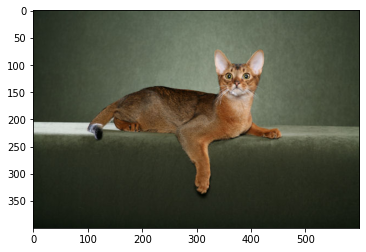

In [5]:
plt.imshow(plt.imread('A:/datasets/oxford-iiit-pet/images/Abyssinian_1.jpg'))

In [6]:
filenames = glob('A:/datasets/oxford-iiit-pet/images/*.jpg')

In [7]:
# for file in filenames:
#     try:
#         img = plt.imread(file)
#         Image.fromarray(img).convert('RGB')
#     except Exception as e:
#         filenames.remove(file)

In [8]:
class PetDataSet(Dataset):

    def __init__(self, filenames, class_to_label, transforms=None):
        self.filenames = filenames
        self.transforms = transforms
        self.class_to_label = class_to_label

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename = self.filenames[i]
        # img = plt.imread(filename)
        # img = Image.fromarray(img).convert('RGB')
        img = Image.open(filename).convert('RGB')
        img = np.array(img).astype(np.uint8)

        if self.transforms is not None:
            img = self.transforms(img)
        label = self.get_label_from_filename(filename)
        return img, label

    def get_label_from_filename(self, filename):
        clazz = filename.rsplit('/', 1)[1].rsplit('_', 1)[0].replace('_', ' ').title()
        return self.class_to_label[clazz]

In [9]:
vgg_format = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

In [10]:
dataset = PetDataSet(filenames, training_data.class_to_idx, vgg_format)

train_ds_length = int(0.8 * len(dataset))
test_ds_length = int(0.2 * len(dataset))

train_ds, test_ds = torch.utils.data.random_split(dataset, [train_ds_length, test_ds_length])

train_dl = DataLoader(train_ds, batch_size=16)
test_dl = DataLoader(test_ds, batch_size=16)

Модель

In [11]:
model = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
model.classifier = torch.nn.Sequential(
    model.classifier,
    torch.nn.Linear(in_features=1000, out_features=number_of_labels, bias=True)
)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [12]:
class Pytorch_Lightning_Classifier(pl.LightningModule):

    def __init__(self, model_):
        super().__init__()
        self.model = model_
        self.loss_func = nn.CrossEntropyLoss()
        self.epoch_accuracy = []
        self.accuracy = []
        self.epoch_loss = []
        self.loss = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = self.loss_func(pred, y)
        self.log('train_loss', loss)
        self.epoch_loss.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=1)
        acc = torch.sum(labels == preds).item() / (len(labels) * 1.0)
        # By default logs it per epoch (weighted average over batches)
        self.epoch_accuracy.append(acc)
        self.log("val_acc", acc)

    def training_epoch_end(self, outputs: EPOCH_OUTPUT) -> None:
        super().training_epoch_end(outputs)
        self.loss.append(np.mean(self.epoch_loss))
        self.accuracy.append(np.mean(self.epoch_accuracy))
        self.epoch_loss.clear()
        self.epoch_accuracy.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = self.loss_func(pred, y)
        pred = torch.argmax(pred, dim=1)
        accuracy = torch.sum(y == pred).item() / (len(y) * 1.0)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', torch.tensor(accuracy), prog_bar=True)
        output = dict({
            'test_loss': loss,
            'test_acc': torch.tensor(accuracy),
        })
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

Навчання на повністю розміченому датасеті

In [13]:
fully_supervised_model = Pytorch_Lightning_Classifier(model)
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     max_epochs=EPOCHS,
                     logger=CSVLogger(save_dir=f"logs/fully_supervised/"))

In [14]:
trainer.fit(fully_supervised_model, train_dl, val_dataloaders=test_dl)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [15]:
trainer.test(fully_supervised_model, test_dl)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8403247594833374     │
│         test_loss         │    0.5003989934921265     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5003989934921265, 'test_acc': 0.8403247594833374}]

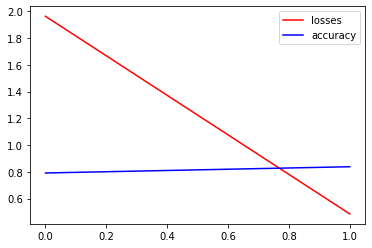

In [16]:
plt.plot(fully_supervised_model.loss, label='losses', color='red')
plt.plot(fully_supervised_model.accuracy, label='accuracy', color='blue')
plt.legend()
plt.show()

Mix-Match

In [17]:
marked_ds_length = int(0.3 * len(train_ds))
unmarked_ds_length = int(0.7 * len(train_ds))
marked_ds, unmarked_ds = torch.utils.data.random_split(train_ds, [marked_ds_length + 1, unmarked_ds_length])
marked_dl = DataLoader(marked_ds, batch_size=8)
unmarked_dl = DataLoader(unmarked_ds, batch_size=8)

In [18]:
class MixMatch_Classifier(pl.LightningModule):

    def __init__(self, model_):
        super().__init__()
        self.model = model_
        self.loss_func = nn.CrossEntropyLoss()
        self.epoch_accuracy = []
        self.accuracy = []
        self.epoch_loss = []
        self.loss = []
        self.augmentations = [
            torchvision.transforms.RandAugment(3,7),
            torchvision.transforms.RandAugment(2,3),
            torchvision.transforms.RandAugment(1,7),
            torchvision.transforms.RandAugment(3,4)
        ]


    def forward(self, x):
        model_predictions = []
        for aug in self.augmentations:
            model_predictions.append(self.model(aug(torchvision.transforms.functional.convert_image_dtype(x, dtype = torch.uint8)).float()))
        return torch.mean(torch.stack(model_predictions), dim = 0)

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = self.loss_func(pred, y)
        self.log('train_loss', loss)
        self.epoch_loss.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.forward(imgs).argmax(dim=1)
        acc = torch.sum(labels == preds).item() / (len(labels) * 1.0)
        # By default logs it per epoch (weighted average over batches)
        self.epoch_accuracy.append(acc)
        self.log("val_acc", acc)

    def training_epoch_end(self, outputs: EPOCH_OUTPUT) -> None:
        super().training_epoch_end(outputs)
        self.loss.append(np.mean(self.epoch_loss))
        self.accuracy.append(np.mean(self.epoch_accuracy))
        self.epoch_loss.clear()
        self.epoch_accuracy.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = self.loss_func(pred, y)
        pred = torch.argmax(pred, dim=1)
        accuracy = torch.sum(y == pred).item() / (len(y) * 1.0)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', torch.tensor(accuracy), prog_bar=True)
        output = dict({
            'test_loss': loss,
            'test_acc': torch.tensor(accuracy),
        })
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer
    
    def predict(self, img):
        return self.forward(img.unsqueeze(0)).argmax(dim=1).item()


In [19]:
semisupervised_model = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
semisupervised_model.classifier = torch.nn.Sequential(
    semisupervised_model.classifier,
    torch.nn.Linear(in_features=1000, out_features=number_of_labels, bias=True)
)

In [20]:
ps_model = Pytorch_Lightning_Classifier(semisupervised_model)
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     max_epochs=EPOCHS,
                     logger=CSVLogger(save_dir=f"logs/partly_supervised/"))
trainer.fit(ps_model, marked_dl, val_dataloaders=test_dl)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [21]:
semisupervised = MixMatch_Classifier(semisupervised_model)
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     max_epochs=EPOCHS,
                     logger=CSVLogger(save_dir=f"logs/semi_supervised/"))
trainer.fit(semisupervised, marked_dl, val_dataloaders=test_dl)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

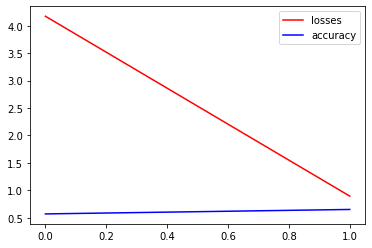

In [22]:
plt.plot(semisupervised.loss, label='losses', color='red')
plt.plot(semisupervised.accuracy, label='accuracy', color='blue')
plt.legend()
plt.show()

In [23]:
mixmatch = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
mixmatch.classifier = torch.nn.Sequential(
    mixmatch.classifier,
    torch.nn.Linear(in_features=1000, out_features=number_of_labels, bias=True)
)

In [24]:
class PseudoLabelDataset(Dataset):

    def __init__(self, model_, filenames, class_to_label, transforms=None, load_pseudolabels=False):
        self.model = model_.cuda()
        self.filenames = filenames
        self.transforms = transforms
        self.class_to_label = class_to_label
        if(load_pseudolabels):
            self.pseudolabels = np.load('pseudolabels.npy',allow_pickle='TRUE').item()
        else:
            self.pseudolabels = self.calculate_pseudolabels()

    @staticmethod
    def from_ss(model_, unmarked: Subset, transforms=None, load_pseudolabels=False):
        return PseudoLabelDataset(model_, filenames=unmarked.dataset.dataset.filenames, class_to_label = unmarked.dataset.dataset.class_to_label, transforms = transforms, load_pseudolabels=load_pseudolabels)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename = self.filenames[i]
        img = Image.open(filename).convert('RGB')
        img = np.array(img).astype(np.uint8)
        if self.transforms is not None:
            img = self.transforms(img)
        label = self.get_label_from_filename(filename)
        return img ,label
    
    def get_label_from_filename(self, filename):
        return self.pseudolabels[filename]
    
    def calculate_pseudolabels(self):
        pseudolabels = {}
        filenames = self.filenames
        for filename in filenames:
            img = Image.open(filename).convert('RGB')
            img = np.array(img).astype(np.uint8)
            if self.transforms is not None:
                img = self.transforms(img)
            logit = self.model(img.cuda().unsqueeze(0))
            predict = logit.argmax(dim=1)
            pseudolabels[filename] = predict.item()
        np.save('pseudolabels.npy', pseudolabels)
        return pseudolabels

In [28]:
mixmatch_classifier = Pytorch_Lightning_Classifier(mixmatch)
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     max_epochs=EPOCHS,
                     logger=CSVLogger(save_dir=f"logs/mix_match/"))
trainer.fit(mixmatch_classifier, 
            marked_dl, 
            val_dataloaders=test_dl)

trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     max_epochs=EPOCHS,
                     logger=CSVLogger(save_dir=f"logs/mix_match/"))
trainer.fit(mixmatch_classifier, 
            DataLoader(PseudoLabelDataset.from_ss(ps_model, 
                                                  unmarked=unmarked_ds, 
                                                  transforms=vgg_format, 
                                                  load_pseudolabels=True)), 
            val_dataloaders=test_dl)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

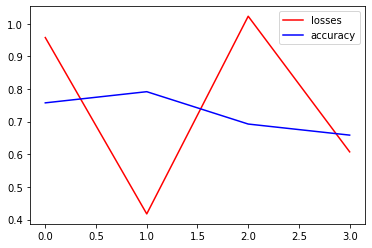

In [29]:
plt.plot(mixmatch_classifier.loss, label='losses', color='red')
plt.plot(mixmatch_classifier.accuracy, label='accuracy', color='blue')
plt.legend()
plt.show()

Порівняння

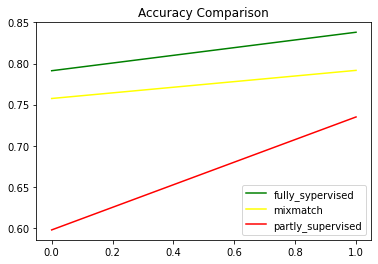

In [31]:
plt.title('Accuracy Comparison')
plt.plot(fully_supervised_model.accuracy, label='fully_sypervised', color='green')
plt.plot(mixmatch_classifier.accuracy[:len(fully_supervised_model.accuracy)], label='mixmatch', color='yellow')
plt.plot(ps_model.accuracy, label='partly_supervised', color='red')

plt.legend()
plt.show()